## *import libraries*

In [1]:
import functions as f

import os
import pandas as pd
from tabulate import tabulate

import pm4py
from pm4py.algo.evaluation import algorithm
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.objects.petri_net.importer.variants import pnml as pnml_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

import warnings
warnings.filterwarnings('ignore')

## *Parameter Setting*

In [2]:
log_number = 9
cpn_ground_truth_dir = f"GT_Models/log{log_number}/"
file_path = f"Transformed_Logs_and_Results/Our/Transformed_Log_Without_Noise/transform_log{log_number}.xes"

key_value = 1
result_dic = {
    'Metrics':['Routine', "Traces", "Length", 'Fitness','Precision','Generalization','Simplicity', 'F_Score', 'coverage', 'Support', 'JC'],
}
params = {
    'encoding': 'freq',   # freq, dur
    'clustering': 'KMEANS',   # DBSCAN, KMEANS
    'eps': 0.01,    # any positive value, Recommended: 0-1
    'minSample': 196,   # any positive value
    'k': 2,  # any positive value
    'export_net': False,    # True, False
}

## *Read Event Log*

In [3]:
event_log = f.read_log(file_path)
event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'], errors='coerce')
event_log['time:timestamp'].ffill(inplace=True)
event_log = event_log[['case:concept:name', 'time:timestamp', 'concept:name']]

print("\n**  Total number of events: ", event_log.shape[0])
print("**  Total number of columns: ", event_log.shape[1])
print("**  Total number of Traces: ", len(event_log['case:concept:name'].unique()))
print("**  Total number of unique activities: ", len(event_log['concept:name'].unique()))
print("\n**  Unique Activites: ", event_log['concept:name'].unique())
print("\n**  Columns: ", list(event_log.columns), "\n")

parsing log, completed traces :: 100%|████████████████████████████████████████████| 2000/2000 [00:11<00:00, 176.84it/s]



**  Total number of events:  28358
**  Total number of columns:  3
**  Total number of Traces:  2000
**  Total number of unique activities:  47

**  Unique Activites:  ['insertValue_name_Web' 'insertValue_surname_Web' 'insertValue_age_Web'
 'insertValue_type_Web' 'clickButton_confirm_Web' 'clickButton_B4_Web'
 'clickButton_Clients_Web' 'insertValue_clientID_Web' 'pressKey_Web'
 'clickButton_update_Web' 'insertValue_address_Web'
 'insertValue_country_Web' 'clickButton_UnbindFile_Web'
 'clickButton_OK_Web' 'clickButton_Confirm_Web' 'clickButton_B5_Web'
 'insertBoolValue_Australian_Web' 'clickButton_Button6_Web'
 'openFile_Excel_Sheet1_data_xls' 'copy_B_Excel' 'paste_Special_code_Web'
 'paste_Country_Web' 'clickButton_Button9_Web'
 'goToUrl_www_webpage2_com_Web' 'clickButton_B3_Web' 'copy_A_Excel'
 'openFile_Excel' 'copy_address_Web' 'paste_A_Excel' 'saveFile_save_Excel'
 'clickButton_ConfirmWithFile_Web' 'clickButton_B1_Web' 'copy_name_Web'
 'paste_name_Excel_B' 'copy_surname_Web' 'past

## *Clustering*

KMEANS
freq




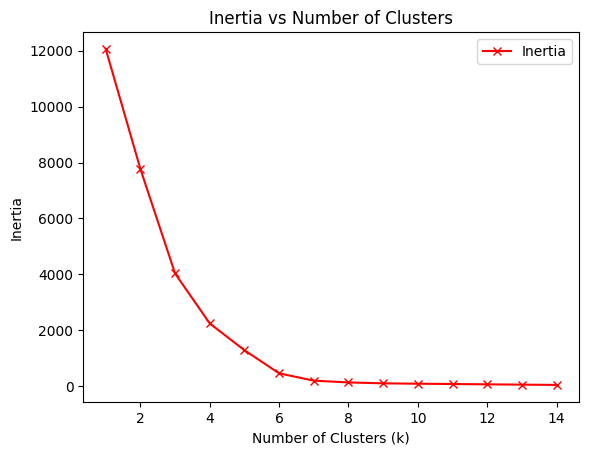

Optimal number of clusters (k) based on the elbow method (Inertia): 5

Estimated number of clusters: 5 

3    526
0    496
1    491
2    275
4    212
Name: KMeans_Cluster, dtype: int64


Activity Log Columns: Index(['case:concept:name', 'time:timestamp', 'concept:name',
       'abstract_activity'],
      dtype='object') 

Total Routies: 5 ['routine_3', 'routine_1', 'routine_4', 'routine_5', 'routine_2']


,case:concept:name,time:timestamp,concept:name,abstract_activity
0,1,2019-03-07 13:09:41,insertValue_name_Web,routine_3
1,1,2019-03-07 13:09:52,insertValue_surname_Web,routine_3
2,1,2019-03-07 13:09:57,insertValue_age_Web,routine_3
3,1,2019-03-07 13:10:09,insertValue_type_Web,routine_3
4,1,2019-03-07 13:10:23,clickButton_confirm_Web,routine_3


In [4]:
session_log, encoded_log, cluster_map = f.clustering(event_log, params)
activity_log, _ = f.assign_clusters(session_log, encoded_log, cluster_map)

print(f"\nActivity Log Columns: {activity_log.columns} \n")
print(f"Total Routies: {len(activity_log['abstract_activity'].unique())} {list(activity_log['abstract_activity'].unique())}")
activity_log.head()

## *Inspect Routines and Routines Activities*

In [5]:
for key, routine_label in cluster_map.items():
    print(f"**Start Processing {routine_label}")
    routine_log = activity_log[activity_log['abstract_activity'] == routine_label]
    routine_activities = set(routine_log['concept:name'])
    print(f"**Count of Unique Activitites in {routine_label} Log: {len(routine_activities)}")
    print(f"**Unique Activities of {routine_label} Log: {routine_activities}\n")
    routine_log.to_csv(f"saved_logs/{routine_label}.csv", index=False)

**Start Processing routine_3
**Count of Unique Activitites in routine_3 Log: 15
**Unique Activities of routine_3 Log: {'insertValue_age_Web', 'clickButton_Confirm_Web', 'insertValue_clientID_Web', 'clickButton_OK_Web', 'insertValue_address_Web', 'clickButton_Clients_Web', 'clickButton_update_Web', 'insertValue_type_Web', 'insertValue_surname_Web', 'pressKey_Web', 'insertValue_name_Web', 'clickButton_confirm_Web', 'clickButton_B4_Web', 'insertValue_country_Web', 'clickButton_UnbindFile_Web'}

**Start Processing routine_1
**Count of Unique Activitites in routine_1 Log: 24
**Unique Activities of routine_1 Log: {'clickButton_B3_Web', 'copy_A_Excel', 'clickButton_Button6_Web', 'clickButton_open_Web', 'insertValue_name_Web', 'clickButton_add_Web', 'clickButton_confirm_Web', 'goToUrl_www_webpage2_com_Web', 'insertValue_code_Web', 'clickButton_cancel_Web', 'paste_name_Excel_B', 'findValue_Excel', 'openFile_Excel_Sheet1_data123_xls', 'copy_code_Web', 'clickButton_OK_Web', 'insertValue_value1_We

## *Util Functions (Evaluation Scores)* 

In [6]:
# Extract transitions (activities) from both models to calculate Jaccard Coefficient
def extract_transitions(net):
    """ Extracts the transitions (activities) from the given Petri net model. """
    return {t.label for t in net.transitions if t.label is not None}


def get_fScore(fitness, precision):
    f_score = (2*fitness*precision)/(fitness+precision)
    return f_score


def get_JC(log, net, im, fm, routine_label):
    gt_routine_activities = extract_transitions(net)
    routine_activities = set(log['concept:name'])
    print(gt_routine_activities, "\n")
    print(routine_activities, "\n")
    print("="*30)

    # Calculate the Jaccard Coefficient (Intersection over Union)
    intersection = routine_activities.intersection(gt_routine_activities)
    union = routine_activities.union(gt_routine_activities)
    jaccard_coefficient = len(intersection) / len(union)

    return jaccard_coefficient


def token_base_evaluation(log, net, im, fm):
    replayed_traces = token_replay.apply(log, net, im, fm)
    
    # Calculate Support (fraction of transitions supported by the log)
    activated_transitions = set()
    for trace in replayed_traces:
        for trans in trace['activated_transitions']:
            if trans is not None:  # Ensure the transition is valid
                activated_transitions.add(trans)
    total_transitions = len(net.transitions)
    support = len(activated_transitions) / total_transitions

    # Calculate Coverage
    covered_traces = sum([1 for trace in replayed_traces if trace['activated_transitions']])
    total_traces = len(log)
    coverage = covered_traces / total_traces

    return support, coverage
    

def alignment_base_evaluation(log, net, im, fm):
    # Apply alignment-based conformance checking
    aligned_traces = alignments.apply_log(log, net, im, fm)
    
    # Calculate Support (fraction of transitions supported by the log)
    activated_transitions = set()
    for trace in aligned_traces:
        for step in trace['alignment']:
            # Check if the step corresponds to a 'model move' (indicating a supported transition)
            if step[0] == step[1] and step[1] is not None:
                activated_transitions.add(step[1])
    total_transitions = len(net.transitions)
    support = len(activated_transitions) / total_transitions
    
    # Calculate Coverage (fraction of traces covered by at least one activated transition)
    covered_traces = sum(1 for trace in aligned_traces if any(step[0] == step[1] and step[1] is not None for step in trace['alignment']))
    total_traces = len(log)
    coverage = covered_traces / total_traces

    return support, coverage


def evaluate_routines(log, net, im, fm, token_base, routine_label):
    gt_routine_activities = extract_transitions(net)
    routine_activities = set(log['concept:name'])

    # case_id = log['case:concept:name'].unique()[0]
    # routine_length = len(log[log['case:concept:name'] == case_id])
    log_traces = len(log['case:concept:name'].unique())

    # Calculate the Jaccard Coefficient (Intersection over Union)
    intersection = routine_activities.intersection(gt_routine_activities)
    union = routine_activities.union(gt_routine_activities)
    jaccard_coefficient = len(intersection) / len(union)

    log = pm4py.convert_to_event_log(log)
    support, coverage = token_base_evaluation(log, net, im, fm) if token_base else alignment_base_evaluation(log, net, im, fm)

    # Calculate fitness, precision, generalization, and F-score
    q_o = algorithm.apply(log, net, im, fm)
    fitness = round(q_o['fitness']['average_trace_fitness'],3)
    prec = round(q_o['precision'],3)
    gen = round(q_o['generalization'],3)
    simp = round(q_o['simplicity'],3)
    f_score = get_fScore(fitness, prec)

    # Print metrics
    print("\nEvaluation Scores:")
    print("=====================")
    print("Fitness: ", fitness)
    print("Precision: ", prec)
    print("Generalization: ", gen)
    print("Simplicity: ", simp)
    
    print(f"\nCoverage: {coverage:.2f}")
    print(f"Support: {support:.2f}")
    print(f"Jaccard Coefficient: {jaccard_coefficient:.2f}")

    return [routine_label, log_traces, len(routine_activities), fitness, prec, gen, simp, f_score, coverage, support, jaccard_coefficient]

# *Routine by Routine Evaluation*

In [7]:
# gt_net, gt_im, gt_fm = pnml_importer.import_net("GT_Models/log6/r2log6.pnml")

# gviz = pn_visualizer.apply(gt_net, gt_im, gt_fm)
# pn_visualizer.view(gviz)

In [8]:
for key, routine_label in cluster_map.items():
    print(f"Start Evaluating the {routine_label}:")
    routine_log = activity_log[activity_log['abstract_activity'] == routine_label]
    JC_scores = {}
    for file_name in os.listdir(cpn_ground_truth_dir):
        model_name = file_name.split('.')[0]
        cpn_ground_truth_path = os.path.join(cpn_ground_truth_dir, file_name)
        gt_net, gt_im, gt_fm = pnml_importer.import_net(cpn_ground_truth_path)
        JC = get_JC(routine_log, gt_net, gt_im, gt_fm, routine_label=routine_label)
        JC_scores[file_name] = JC
        print(f"JC Score of {routine_label} is {JC} with {model_name}")
        
    # Find the key with the maximum value
    max_key = max(JC_scores, key=JC_scores.get)
    max_value = JC_scores[max_key]

    # Output the result
    print(f"\nMaximum JC Score of {routine_label} is {max_value}")

    cpn_ground_truth_path = os.path.join(cpn_ground_truth_dir, max_key)
    gt_net, gt_im, gt_fm = pnml_importer.import_net(cpn_ground_truth_path)
    scores = evaluate_routines(routine_log, gt_net, gt_im, gt_fm, token_base=False, routine_label=routine_label)
    result_dic[key_value] = scores
    key_value += 1
    print("\n\n\n")

Start Evaluating the routine_3:
{'insertValue_age_Web', 'insertValue_code_Web', 'clickButton_cancel_Web', 'paste_name_Excel_B', 'insertValue_value1_Web', 'clickButton_OK_Web', 'clickButton_B7_Web', 'insertValue_type_Web', 'clickButton_open_Web', 'clickButton_B2_Web', 'insertValue_surname_Web', 'copy_code_Web', 'clickButton_confirm_Web', 'insertValue_name_Web'} 

{'insertValue_age_Web', 'clickButton_Confirm_Web', 'insertValue_clientID_Web', 'clickButton_OK_Web', 'insertValue_address_Web', 'clickButton_Clients_Web', 'clickButton_update_Web', 'insertValue_type_Web', 'insertValue_surname_Web', 'pressKey_Web', 'insertValue_name_Web', 'clickButton_confirm_Web', 'clickButton_B4_Web', 'insertValue_country_Web', 'clickButton_UnbindFile_Web'} 

JC Score of routine_3 is 0.2608695652173913 with r10log9
{'insertValue_age_Web', 'insertValue_code_Web', 'paste_name_Excel_B', 'insertValue_value1_Web', 'clickButton_OK_Web', 'copy_code_Web', 'clickButton_B7_Web', 'insertValue_type_Web', 'clickButton_open

replaying log with TBR, completed variants :: 100%|███████████████████████████████████| 15/15 [00:00<00:00, 578.46it/s]



Evaluation Scores:
Fitness:  1.0
Precision:  1.0
Generalization:  0.94
Simplicity:  1.0

Coverage: 1.00
Support: 0.94
Jaccard Coefficient: 1.00




Start Evaluating the routine_1:
{'insertValue_age_Web', 'insertValue_code_Web', 'clickButton_cancel_Web', 'paste_name_Excel_B', 'insertValue_value1_Web', 'clickButton_OK_Web', 'clickButton_B7_Web', 'insertValue_type_Web', 'clickButton_B2_Web', 'insertValue_surname_Web', 'clickButton_open_Web', 'copy_code_Web', 'clickButton_confirm_Web', 'insertValue_name_Web'} 

{'clickButton_B3_Web', 'copy_A_Excel', 'clickButton_Button6_Web', 'clickButton_open_Web', 'insertValue_name_Web', 'clickButton_add_Web', 'clickButton_confirm_Web', 'goToUrl_www_webpage2_com_Web', 'insertValue_code_Web', 'clickButton_cancel_Web', 'paste_name_Excel_B', 'findValue_Excel', 'openFile_Excel_Sheet1_data123_xls', 'copy_code_Web', 'clickButton_OK_Web', 'insertValue_value1_Web', 'clickButton_B2_Web', 'insertValue_surname_Web', 'openFile_Excel_Sheet1_data_xls', 'insertValue_a

replaying log with TBR, completed variants :: 100%|█████████████████████████████████| 109/109 [00:00<00:00, 545.38it/s]



Evaluation Scores:
Fitness:  0.846
Precision:  0.615
Generalization:  0.901
Simplicity:  1.0

Coverage: 1.00
Support: 1.00
Jaccard Coefficient: 0.67




Start Evaluating the routine_4:
{'insertValue_age_Web', 'insertValue_code_Web', 'clickButton_cancel_Web', 'paste_name_Excel_B', 'insertValue_value1_Web', 'clickButton_OK_Web', 'clickButton_B7_Web', 'clickButton_B2_Web', 'clickButton_open_Web', 'insertValue_type_Web', 'insertValue_surname_Web', 'copy_code_Web', 'clickButton_confirm_Web', 'insertValue_name_Web'} 

{'insertValue_age_Web', 'paste_Special_code_Web', 'clickButton_OK_Web', 'clickButton_Button6_Web', 'copy_B_Excel', 'clickButton_B5_Web', 'paste_Country_Web', 'insertValue_type_Web', 'insertValue_surname_Web', 'goToUrl_www_webpage2_com_Web', 'openFile_Excel_Sheet1_data_xls', 'insertValue_name_Web', 'clickButton_confirm_Web', 'clickButton_Button9_Web', 'goToUrl_www_webpage_com_Web', 'insertBoolValue_Australian_Web'} 

JC Score of routine_4 is 0.25 with r10log9
{'insertValue_age_

replaying log with TBR, completed variants :: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 617.01it/s]



Evaluation Scores:
Fitness:  0.965
Precision:  1.0
Generalization:  0.955
Simplicity:  1.0

Coverage: 1.00
Support: 1.00
Jaccard Coefficient: 0.94




Start Evaluating the routine_5:
{'insertValue_age_Web', 'paste_name_Excel_B', 'clickButton_cancel_Web', 'insertValue_code_Web', 'insertValue_value1_Web', 'clickButton_OK_Web', 'copy_code_Web', 'clickButton_B7_Web', 'insertValue_type_Web', 'clickButton_B2_Web', 'clickButton_open_Web', 'insertValue_surname_Web', 'insertValue_name_Web', 'clickButton_confirm_Web'} 

{'openFile_Excel', 'insertValue_age_Web', 'insertValue_clientID_Web', 'clickButton_OK_Web', 'insertValue_address_Web', 'clickButton_Clients_Web', 'clickButton_update_Web', 'insertValue_type_Web', 'insertValue_surname_Web', 'pressKey_Web', 'copy_address_Web', 'insertValue_name_Web', 'clickButton_confirm_Web', 'clickButton_ConfirmWithFile_Web', 'clickButton_B4_Web', 'saveFile_save_Excel', 'insertValue_country_Web', 'paste_A_Excel'} 

JC Score of routine_5 is 0.23076923076923078 wi

replaying log with TBR, completed variants :: 100%|███████████████████████████████████| 36/36 [00:00<00:00, 680.97it/s]



Evaluation Scores:
Fitness:  0.996
Precision:  1.0
Generalization:  0.931
Simplicity:  1.0

Coverage: 1.00
Support: 1.00
Jaccard Coefficient: 1.00




Start Evaluating the routine_2:
{'insertValue_age_Web', 'insertValue_code_Web', 'clickButton_cancel_Web', 'paste_name_Excel_B', 'insertValue_value1_Web', 'clickButton_OK_Web', 'clickButton_B7_Web', 'insertValue_type_Web', 'clickButton_open_Web', 'insertValue_surname_Web', 'clickButton_B2_Web', 'copy_code_Web', 'clickButton_confirm_Web', 'insertValue_name_Web'} 

{'paste_surname_Excel_B', 'insertValue_age_Web', 'paste_name_Excel_B', 'copy_surname_Web', 'clickButton_B1_Web', 'clickButton_OK_Web', 'insertValue_type_Web', 'insertValue_surname_Web', 'insertValue_name_Web', 'clickButton_confirm_Web', 'copy_name_Web', 'clickButton_add_Web'} 

JC Score of routine_2 is 0.3684210526315789 with r10log9
{'insertValue_age_Web', 'insertValue_code_Web', 'paste_name_Excel_B', 'insertValue_value1_Web', 'clickButton_OK_Web', 'copy_code_Web', 'clickButton

replaying log with TBR, completed variants :: 100%|███████████████████████████████████| 12/12 [00:00<00:00, 707.92it/s]


Evaluation Scores:
Fitness:  0.846
Precision:  0.833
Generalization:  0.876
Simplicity:  1.0

Coverage: 1.00
Support: 0.92
Jaccard Coefficient: 0.85






## *Summary of Evaluation Scores*

In [9]:
# # Initialize a list for the average values
# average_values = ["Average"]

# # Calculate the sum of Traces for weighted calculations and add as a separate metric
# total_traces = sum(result_dic[key][1] for key in result_dic if isinstance(key, int))
# average_values.append(total_traces)  # Sum of Traces (instead of an average)

# # Calculate averages and weighted means for each metric column
# for i in range(2, len(result_dic[1])):  # Start from index 2 to skip Routine and Traces
#     values = [result_dic[key][i] for key in result_dic if isinstance(key, int)]
    
#     if i in [9, 10, 11]:  # For Coverage, Support, and JC indices
#         # Calculate weighted mean
#         weighted_mean = sum(result_dic[key][i] * result_dic[key][1] for key in result_dic if isinstance(key, int)) / total_traces
#         average_values.append(weighted_mean)
#     else:
#         # For other metrics, calculate a simple average
#         avg = sum(values) / len(values)
#         average_values.append(avg)

# # Find the next available numeric key
# next_key = max([key for key in result_dic if isinstance(key, int)]) + 1

# # Add the new row to result_dic with the calculated averages
# result_dic[next_key] = average_values


In [10]:
# Initialize two lists for average values
simple_average_values = ["Simple Average"]
weighted_average_values = ["Weighted Average"]

# Calculate the sum of Traces for weighted calculations
total_traces = sum(result_dic[key][1] for key in result_dic if isinstance(key, int))

# Append the total traces to both average rows
simple_average_values.append(total_traces)  # Sum of Traces for simple average
weighted_average_values.append(total_traces)  # Sum of Traces for weighted average

# Calculate averages for each metric column
for i in range(2, len(result_dic[1])):  # Start from index 2 to skip Routine and Traces
    values = [result_dic[key][i] for key in result_dic if isinstance(key, int)]

    if i == 2:
        # Special case: Simple average for trace length (index 2)
        simple_avg = sum(values) / len(values)
        weighted_avg = simple_avg  # Use the same for weighted average
    else:
        # Simple average for other metrics
        simple_avg = sum(values) / len(values)
        
        # Weighted average for other metrics
        weighted_avg = sum(result_dic[key][i] * result_dic[key][1] for key in result_dic if isinstance(key, int)) / total_traces

    # Append the averages to the respective lists
    simple_average_values.append(simple_avg)
    weighted_average_values.append(weighted_avg)

# Find the next available numeric keys
next_key_simple = max([key for key in result_dic if isinstance(key, int)]) + 1
next_key_weighted = next_key_simple + 1

# Add the new rows to result_dic
result_dic[next_key_simple] = simple_average_values
result_dic[next_key_weighted] = weighted_average_values

In [11]:
result_df = pd.DataFrame(result_dic)
result_df = result_df.set_index('Metrics')
# displaying the DataFrame
print(tabulate(result_df.T, headers = 'keys', tablefmt = 'psql'))
# result_df.T

+----+------------------+----------+----------+-----------+-------------+------------------+--------------+-----------+------------+-----------+----------+
|    | Routine          |   Traces |   Length |   Fitness |   Precision |   Generalization |   Simplicity |   F_Score |   coverage |   Support |       JC |
|----+------------------+----------+----------+-----------+-------------+------------------+--------------+-----------+------------+-----------+----------|
|  1 | routine_3        |      275 |       15 |  1        |    1        |         0.94     |            1 |  1        |          1 |  0.9375   | 1        |
|  2 | routine_1        |      496 |       24 |  0.846    |    0.615    |         0.901    |            1 |  0.712238 |          1 |  1        | 0.666667 |
|  3 | routine_4        |      526 |       16 |  0.965    |    1        |         0.955    |            1 |  0.982188 |          1 |  1        | 0.9375   |
|  4 | routine_5        |      212 |       18 |  0.996    |    1